In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../src/utils')

import ipdb
import itertools
from collections import Counter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from preprocessing import Preprocessing
from config import Config 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [3]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_2021-02-01_22-27-13.862993_labeled.json")

# Data loading and preparation

## load

In [4]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()

## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [5]:
config = Config.from_file("config_notebook.yaml")
corpus = Preprocessing(
        corpus,
        config=config.preprocessing,
    ).apply_preprocessing()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2204it [00:09, 221.72it/s]


### tfidf

The TfidfVectorizer does additionally also tokenization and stop word removal.

In [6]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

Since we implemented our own preprocessing this is not necessary. Therefore we don't use tokenization and lowercase. Since we didn't implement stop word removal yet(TODO: false -> remove stopword removal by sklearn) we use the stopword removal by sklearn.

In [7]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])

vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

## get optimal k

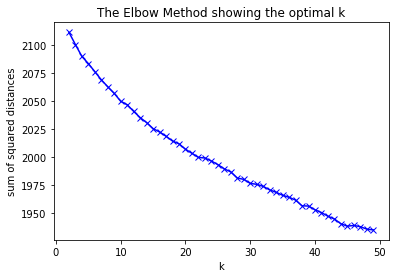

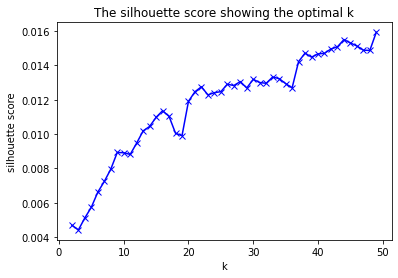

In [8]:
def find_k(corpus, num_topics):
    sum_of_suared_distances = []
    silhouette_scores = []
    K = range(2,num_topics)
    for k in K:
        model = KMeans(n_clusters=k, random_state=10)
        model.fit(corpus)
        sum_of_suared_distances.append(model.inertia_)
        labels = model.labels_
        silhouette_scores.append(metrics.silhouette_score(corpus, labels, metric='euclidean'))

    # Plot the elbow
    plt.plot(K, sum_of_suared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # Plot silhouette scores
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('The silhouette score showing the optimal k')
    plt.show()
find_k(tfidf_corpus, 50)

 There is no elbow visible. There could be several reasons for this: https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering

Silhouette score explained:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
TODO: proper visualization of silhouette score

Elbow Method explained: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

# Clustering

In [9]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_and_get_clusters(model, vectorizer, n_components=None, svd=None):
    print("Top terms per cluster:")
    if n_components:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        cluster = []
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            cluster.append(terms[ind])
        clusters.append(cluster)
        print("\n")
    return clusters
    
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer)


Top terms per cluster:
Cluster 0:
 network
 neural
 bayesian
 structure
 model
 learning
 layer
 deep
 data
 algorithm


Cluster 1:
 inference
 variational
 process
 model
 gaussian
 approximation
 bayesian
 posterior
 likelihood
 latent


Cluster 2:
 learning
 label
 active
 algorithm
 query
 complexity
 class
 bound
 supervised
 sample


Cluster 3:
 clustering
 cluster
 algorithm
 density
 data
 based
 hierarchical
 spectral
 graph
 point


Cluster 4:
 selection
 regression
 model
 feature
 variable
 estimator
 method
 data
 lasso
 high


Cluster 5:
 classifier
 loss
 classification
 class
 risk
 bound
 data
 margin
 learning
 algorithm


Cluster 6:
 model
 topic
 data
 learning
 image
 latent
 language
 system
 representation
 mixture


Cluster 7:
 kernel
 learning
 space
 function
 regression
 reproducing
 hilbert
 algorithm
 method
 data


Cluster 8:
 policy
 reinforcement
 learning
 regret
 action
 algorithm
 bandit
 decision
 agent
 reward


Cluster 9:
 graph
 graphical
 model
 

Since the words which define the clusters look weird I use the sklearn preprocessing in the following. Our preprocessing should be improved. Or we decide to just use the sklearn preprocessing. But as far as I know they don't use lemmatization and stemming (TODO: true?)
With no stemming, the use of nltk and lowering the words, the result seems to be better. Therfore we use our own preprocessing again.

In [10]:
model_skelarn_preprocessed = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_skelarn_preprocessed, tfidf_corpus_sklearn_preprocessed)
print_and_get_clusters(model_skelarn_preprocessed, vectorizer_sklearn)


Top terms per cluster:
Cluster 0:
 online
 regret
 loss
 algorithm
 losses
 algorithms
 learning
 bound
 bandit
 problem


Cluster 1:
 regression
 estimator
 estimation
 high
 data
 covariance
 dimensional
 method
 sparse
 lasso


Cluster 2:
 learning
 classification
 data
 machine
 classifiers
 training
 algorithms
 supervised
 support
 class


Cluster 3:
 learning
 neural
 reinforcement
 networks
 model
 algorithms
 deep
 optimization
 sampling
 network


Cluster 4:
 kernel
 kernels
 learning
 reproducing
 hilbert
 space
 regression
 regularization
 data
 function


Cluster 5:
 causal
 models
 graph
 graphical
 variables
 graphs
 networks
 structure
 data
 model


Cluster 6:
 convex
 optimization
 bounds
 problems
 loss
 problem
 algorithms
 convergence
 algorithm
 function


Cluster 7:
 manifold
 similarity
 data
 dimensionality
 dimensional
 reduction
 information
 learning
 embedding
 dimension


Cluster 8:
 inference
 variational
 gaussian
 bayesian
 model
 process
 models
 laten

[['online',
  'regret',
  'loss',
  'algorithm',
  'losses',
  'algorithms',
  'learning',
  'bound',
  'bandit',
  'problem'],
 ['regression',
  'estimator',
  'estimation',
  'high',
  'data',
  'covariance',
  'dimensional',
  'method',
  'sparse',
  'lasso'],
 ['learning',
  'classification',
  'data',
  'machine',
  'classifiers',
  'training',
  'algorithms',
  'supervised',
  'support',
  'class'],
 ['learning',
  'neural',
  'reinforcement',
  'networks',
  'model',
  'algorithms',
  'deep',
  'optimization',
  'sampling',
  'network'],
 ['kernel',
  'kernels',
  'learning',
  'reproducing',
  'hilbert',
  'space',
  'regression',
  'regularization',
  'data',
  'function'],
 ['causal',
  'models',
  'graph',
  'graphical',
  'variables',
  'graphs',
  'networks',
  'structure',
  'data',
  'model'],
 ['convex',
  'optimization',
  'bounds',
  'problems',
  'loss',
  'problem',
  'algorithms',
  'convergence',
  'algorithm',
  'function'],
 ['manifold',
  'similarity',
  'data'

lemmatization would be good, because the defining words are redundant(e.g. models and model, graphs and graph, ...)

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


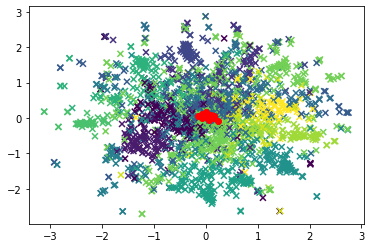

In [11]:
def plot(model, corpus, n_components=None):
    random_state = 1
    centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(np.concatenate((corpus, centroids)))
    else:
        transformed = tsne.fit_transform(np.concatenate((corpus.todense(), centroids)))
    plt.scatter(transformed[:-num_topics, 0], transformed[:-num_topics, 1], c=model.labels_, marker='x')
    plt.scatter(transformed[-num_topics:, 0], transformed[-num_topics:, 1], c="red", marker='o')

    plt.show()
plot(model, tfidf_corpus)

# LSA and kmeans

In [12]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

n_components:  2


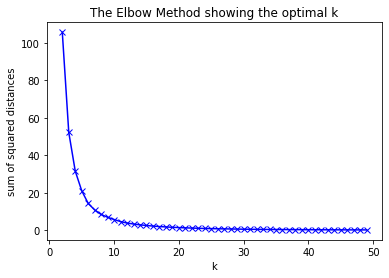

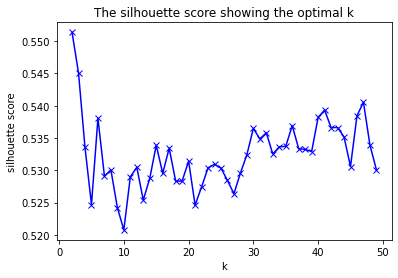

n_components:  3


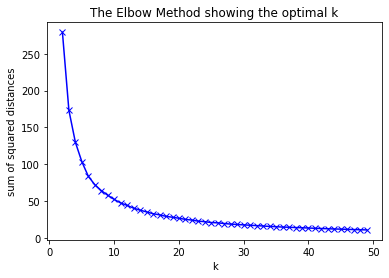

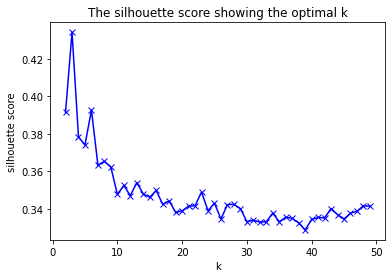

n_components:  4


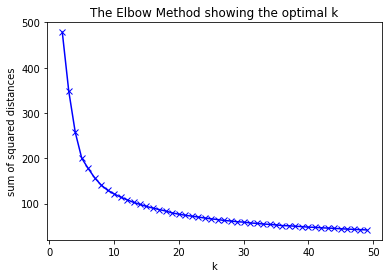

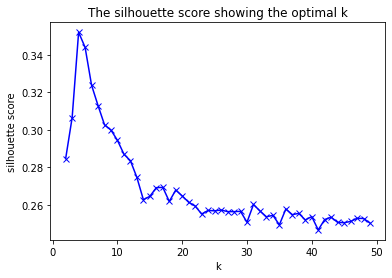

n_components:  5


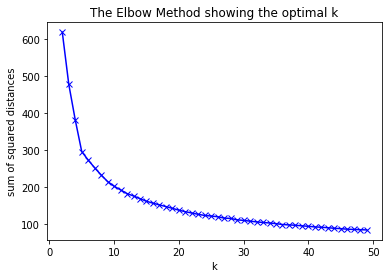

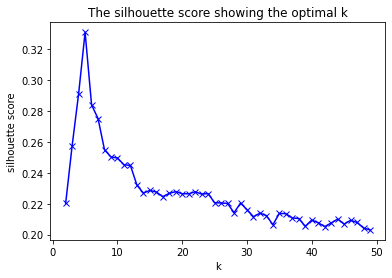

n_components:  6


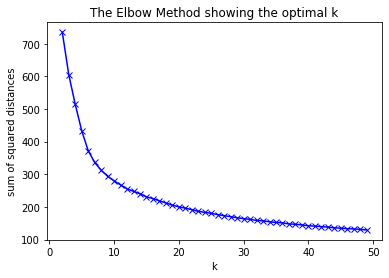

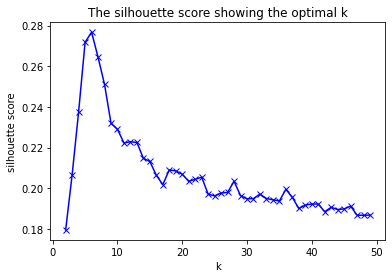

n_components:  7


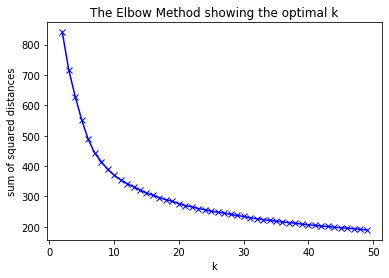

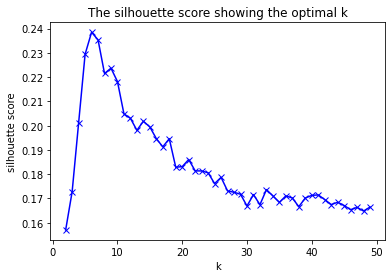

n_components:  8


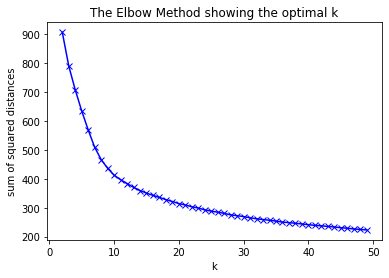

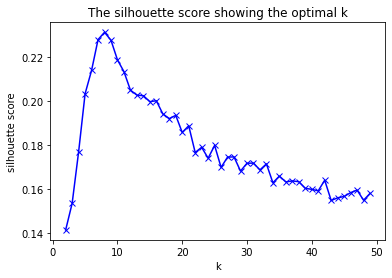

n_components:  9


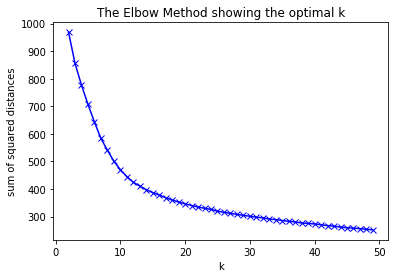

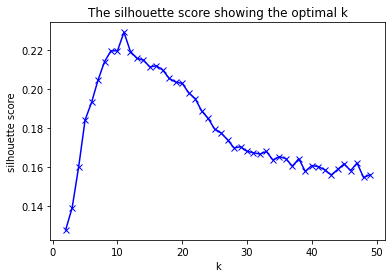

n_components:  10


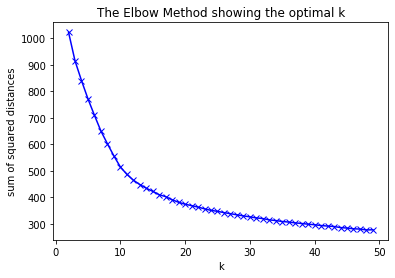

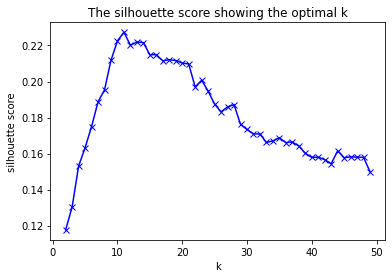

In [13]:
def find_n_components_and_k(corpus):
    for n_components in [2,3,4,5,6,7,8,9,10]:
        print("n_components: ", n_components)
        X, svd = get_lsa_transformation(n_components, corpus)
        find_k(X, 50)
        
find_n_components_and_k(tfidf_corpus)

With LSA and kmeans a elbow is visible! The peak of the silhouette score moves to the right the higher n_component.
The optimal cluster number seems to be 15? With n_components = 2. So maybe use num_topics= 15 and n_components=2?

In [36]:
n_components = 2
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_lsa, X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, n_components=n_components, svd=svd)


Top terms per cluster:
Cluster 0:
 kernel
 learning
 function
 loss
 algorithm
 bound
 problem
 convex
 regularization
 rate


Cluster 1:
 model
 learning
 algorithm
 data
 method
 problem
 function
 network
 set
 variable


Cluster 2:
 model
 data
 algorithm
 method
 learning
 network
 variable
 bayesian
 problem
 graph


Cluster 3:
 kernel
 learning
 algorithm
 problem
 function
 method
 bound
 data
 loss
 regression


Cluster 4:
 model
 data
 network
 variable
 bayesian
 method
 inference
 graph
 algorithm
 structure


Cluster 5:
 kernel
 learning
 algorithm
 method
 problem
 data
 function
 model
 bound
 regression


Cluster 6:
 kernel
 learning
 algorithm
 function
 problem
 bound
 loss
 method
 convex
 rate


Cluster 7:
 model
 data
 algorithm
 learning
 method
 network
 problem
 variable
 set
 graph


Cluster 8:
 learning
 algorithm
 kernel
 model
 data
 method
 problem
 function
 bound
 based


Cluster 9:
 model
 data
 network
 method
 variable
 algorithm
 learning
 bayesian
 g

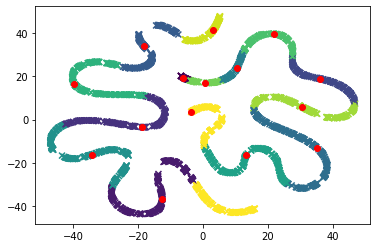

In [37]:
plot(model_lsa, X, n_components=n_components)

cluster centers look better than without lsa.

# Remove words which appear often in all clusters

In [38]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 10, 'learning': 8, 'data': 8, 'model': 6, 'method': 6, 'problem': 5, 'graph': 3, 'function': 3, 'bayesian': 2, 'structure': 2, 'inference': 2, 'gaussian': 2, 'latent': 2, 'class': 2, 'bound': 2, 'regression': 2, 'variable': 2, 'lasso': 2, 'classification': 2, 'kernel': 2, 'machine': 2, 'optimization': 2, 'network': 1, 'neural': 1, 'layer': 1, 'deep': 1, 'variational': 1, 'process': 1, 'approximation': 1, 'posterior': 1, 'likelihood': 1, 'label': 1, 'active': 1, 'query': 1, 'complexity': 1, 'supervised': 1, 'sample': 1, 'clustering': 1, 'cluster': 1, 'density': 1, 'based': 1, 'hierarchical': 1, 'spectral': 1, 'point': 1, 'selection': 1, 'feature': 1, 'estimator': 1, 'high': 1, 'classifier': 1, 'loss': 1, 'risk': 1, 'margin': 1, 'topic': 1, 'image': 1, 'language': 1, 'system': 1, 'representation': 1, 'mixture': 1, 'space': 1, 'reproducing': 1, 'hilbert': 1, 'policy': 1, 'reinforcement': 1, 'regret': 1, 'action': 1, 'bandit': 1, '

In [39]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 14, 'learning': 13, 'method': 13, 'problem': 12, 'data': 12, 'function': 10, 'kernel': 9, 'model': 9, 'bound': 8, 'loss': 6, 'network': 6, 'variable': 6, 'graph': 5, 'bayesian': 4, 'regression': 4, 'convex': 3, 'rate': 3, 'set': 3, 'inference': 3, 'regularization': 2, 'structure': 2, 'based': 2, 'causal': 1})>

Words that should be removed are algorithm, data, learning, method, model. This insight corresponds to the insight we get by printing the topwords of BoW and tfidf corpuses (milestone) 

In [40]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [41]:
corpus_new = load_data()

config = Config.from_file("config_notebook_stopwords.yaml")
corpus_stopwords = Preprocessing(
        corpus_new,
        config=config.preprocessing,
    ).apply_preprocessing()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2204it [00:11, 190.89it/s]


In [42]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [43]:
n_components = 2
X_stopwords, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
num_topics = 15
model_stopwords = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_stopwords, X_stopwords)
clusters_with_lsa_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
 network
 problem
 variable
 graph
 bayesian
 approach
 set
 based
 function
 inference


Cluster 1:
 kernel
 function
 problem
 bound
 regression
 matrix
 based
 classification
 class
 set


Cluster 2:
 kernel
 problem
 function
 bound
 based
 regression
 set
 matrix
 approach
 feature


Cluster 3:
 network
 variable
 graph
 bayesian
 inference
 problem
 structure
 causal
 approach
 distribution


Cluster 4:
 kernel
 function
 bound
 regression
 problem
 space
 loss
 regularization
 svm
 machine


Cluster 5:
 problem
 function
 network
 set
 based
 approach
 variable
 matrix
 bound
 regression


Cluster 6:
 kernel
 function
 problem
 bound
 regression
 space
 loss
 classification
 machine
 regularization


Cluster 7:
 network
 variable
 graph
 bayesian
 inference
 causal
 structure
 graphical
 problem
 distribution


Cluster 8:
 network
 variable
 problem
 graph
 bayesian
 inference
 approach
 structure
 set
 distribution


Cluster 9:
 kernel
 functio

In [44]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 14, 'function': 12, 'bound': 10, 'regression': 10, 'set': 9, 'kernel': 9, 'based': 8, 'matrix': 8, 'network': 7, 'approach': 7, 'variable': 6, 'graph': 5, 'bayesian': 5, 'classification': 5, 'inference': 4, 'class': 4, 'space': 4, 'loss': 4, 'structure': 3, 'distribution': 3, 'regularization': 3, 'machine': 3, 'causal': 2, 'svm': 2, 'feature': 1, 'graphical': 1, 'vector': 1})>

Now we have other words that are in multiple clusters.

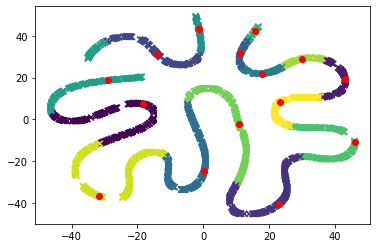

In [45]:
plot(model_stopwords, X_stopwords, n_components=n_components)

The clusters look now not as good as before in my opinion. Maybe we need new k and n_components?

n_components:  2


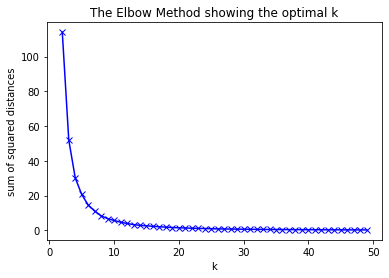

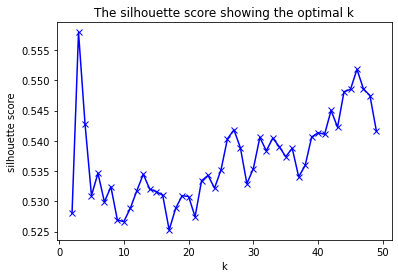

n_components:  3


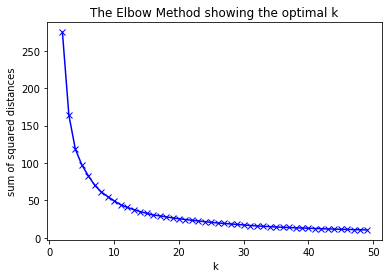

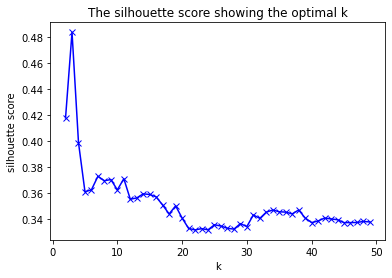

n_components:  4


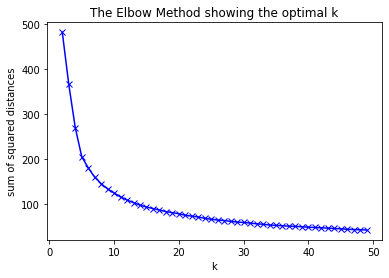

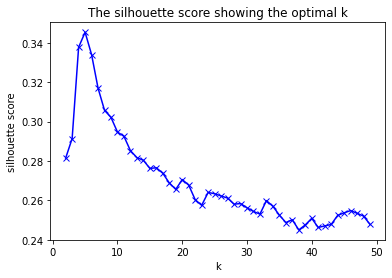

n_components:  5


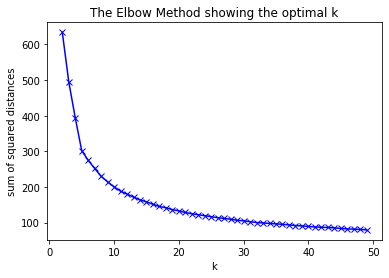

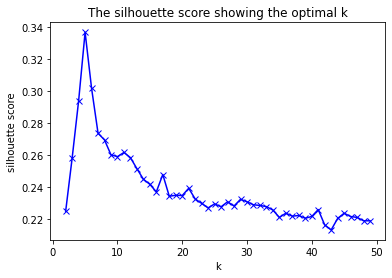

n_components:  6


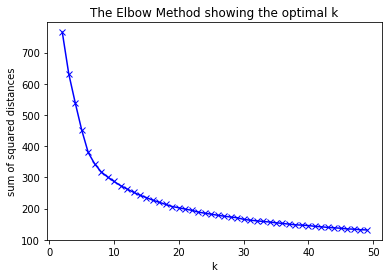

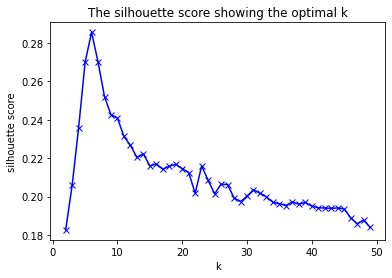

n_components:  7


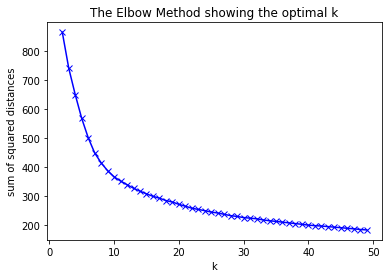

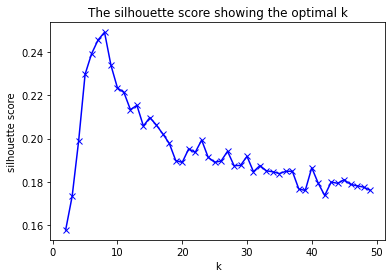

n_components:  8


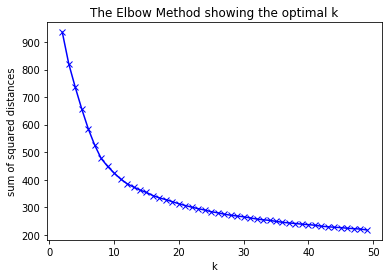

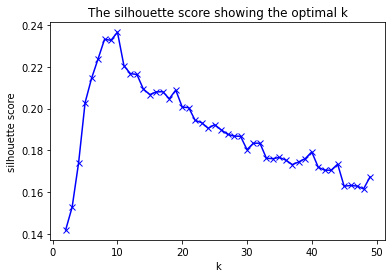

n_components:  9


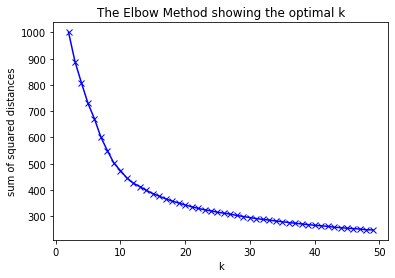

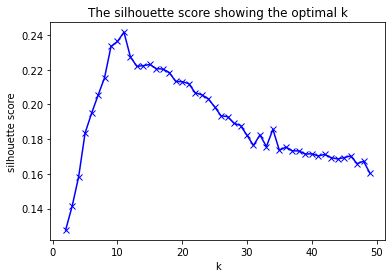

n_components:  10


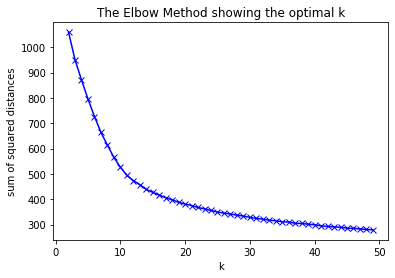

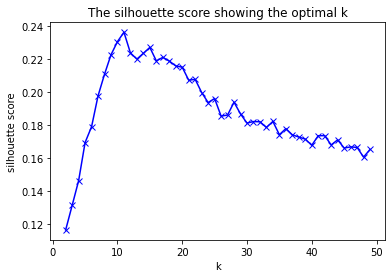

In [24]:
find_n_components_and_k(tfidf_corpus_stopwords)

Looks similar to before.

# Spectral Embedding
find optimal n_components

In [25]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

def plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(n, silhouettes_scores)
    ax1.set_title('silhouettes_score')
    ax2.plot(n, calinski_harabasz_scores, label="calinski_harabasz_scores")
    ax2.set_title('calinski_harabasz_scores')
    ax3.plot(n, davies_bouldin_scores, label="davies_bouldin_scores")
    ax3.set_title('davies_bouldin_scores')
    plt.show()
    

def find_n_components_spectral():
    n = [2,5,10,15,20,25,30]
    vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
    tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=n_component).fit_transform(tfidf_corpus_spec_embedding.toarray())
        model_spectral = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
        model_spectral.fit(tfidf_corpus_spec_embedding_array)
        score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

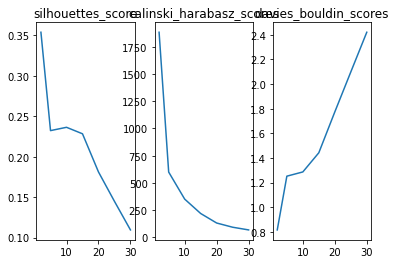

In [26]:
find_n_components_spectral()

2 is best

In [27]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
spectral_embedding = SpectralEmbedding(n_components=2)
tfidf_corpus_spec_embedding_array = spectral_embedding.fit_transform(tfidf_corpus_spec_embedding.toarray())

In [28]:
model_spectral = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
model_spectral.fit(tfidf_corpus_spec_embedding_array)

KMeans(max_iter=100, n_clusters=15, n_init=1)

Getting the top terms of a cluster with the centroids is only possible, when getting the inverse spectral embedding of the centroids. Since this seems not to be possible, the top terms get extracted here the same way as in the other clustering algorithms, by getting the top words of each cluster.

In [29]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words

def print_and_get_clusters_manually(model, vectorizer, corpus, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(np.max(model.labels_)+1):
        print("Cluster %d:" % i),
        vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[np.where(model.labels_ == i)])
        top_words = get_top_words(vectorizer, tfidf_corpus)
        print(top_words)
        clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters

In [30]:
clusters_spectral = print_and_get_clusters_manually(model_spectral, vectorizer_spec_embedding, corpus)

Top terms per cluster:
Cluster 0:
('matrix', 'rank', 'low', 'algorithm', 'completion', 'problem', 'norm', 'bound', 'method', 'covariance')


Cluster 1:
('network', 'model', 'data', 'learning', 'neural', 'bayesian', 'algorithm', 'deep', 'method', 'structure')


Cluster 2:
('data', 'algorithm', 'model', 'clustering', 'method', 'problem', 'learning', 'function', 'set', 'regression')


Cluster 3:
('model', 'graph', 'algorithm', 'data', 'method', 'variable', 'gaussian', 'high', 'selection', 'dimensional')


Cluster 4:
('learning', 'machine', 'library', 'algorithm', 'data', 'python', 'source', 'model', 'language', 'package')


Cluster 5:
('learning', 'kernel', 'algorithm', 'classifier', 'data', 'problem', 'classification', 'class', 'method', 'function')


Cluster 6:
('model', 'causal', 'inference', 'data', 'variable', 'graph', 'network', 'latent', 'graphical', 'method')


Cluster 7:
('learning', 'data', 'algorithm', 'feature', 'class', 'machine', 'classification', 'problem', 'set', 'method')

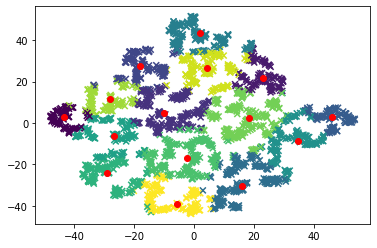

In [31]:
plot(model_spectral, tfidf_corpus_spec_embedding_array, n_components=2)

With Spectral Embedding and kmeans it looks nice clustered.

In [32]:
terms = list(itertools.chain.from_iterable(clusters_spectral))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 14, 'method': 14, 'data': 12, 'problem': 11, 'learning': 10, 'model': 9, 'function': 6, 'bound': 5, 'kernel': 4, 'matrix': 3, 'network': 3, 'set': 3, 'regression': 3, 'variable': 3, 'bayesian': 2, 'clustering': 2, 'graph': 2, 'selection': 2, 'machine': 2, 'classification': 2, 'class': 2, 'feature': 2, 'rate': 2, 'based': 2, 'rank': 1, 'low': 1, 'completion': 1, 'norm': 1, 'covariance': 1, 'neural': 1, 'deep': 1, 'structure': 1, 'gaussian': 1, 'high': 1, 'dimensional': 1, 'library': 1, 'python': 1, 'source': 1, 'language': 1, 'package': 1, 'classifier': 1, 'causal': 1, 'inference': 1, 'latent': 1, 'graphical': 1, 'gradient': 1, 'stochastic': 1, 'convex': 1, 'convergence': 1, 'optimization': 1, 'estimator': 1, 'sparse': 1, 'time': 1, 'loss': 1})>

# Metrics

In [46]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

scores = []
score = list(calc_scores(tfidf_corpus, model))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_sklearn_preprocessed, model_skelarn_preprocessed))
score.insert(0, 'model_skelarn_preprocessed')
scores.append(score)

score = list(calc_scores_arr(X, model_lsa))
score.insert(0, 'model_lsa')
scores.append(score)

score = list(calc_scores_arr(X_stopwords, model_stopwords))
score.insert(0, 'model_stopwords')
scores.append(score)

score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.010273                 7.303010   
1     model_skelarn_preprocessed          0.007714                 5.798601   
2                      model_lsa          0.520976             16793.343966   
3                model_stopwords          0.533562             14589.234888   
4  model with spectral embedding          0.340198              1813.037559   

   davies_bouldin_score  
0              7.729332  
1              8.553913  
2              0.534719  
3              0.510942  
4              0.833961  


In [35]:
scores.to_csv("scores/kmeans.csv")